In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
from tqdm import tqdm
import pickle
from functions import get_dyn_v2, get_prop_abs_v2, create_R_v1, get_var_hist,simulate_traj, get_p_x4_short_time, get_steady_mean
from setup import setup_matplotlib, one_col, std_height, two_col
from functions import SimulationManager, SolverManager,EigenvectorManager, forces_dict
from timeit import default_timer as timer

setup_matplotlib()

np.random.seed(42)

In [3]:
version = 2

s = 1
D = s**2/2
max_t = 6 #2
ntau = 3
N_x = 25
hist_sigma = 4
force = "cubic"
avg_part = 4

f = 15
N_p = 2_000
N_loop = 10
ntau_sim = f*ntau

ltaus = np.concatenate(([0, 0.02, 0.05], np.arange(0.1,1.1,0.1) ))
# ltaus = np.array([0, 0.003,0.004, 0.005, 0.006,0.0075, 0.01, 0.0125, 0.015,0.0175, 0.02, 0.025,0.03, 0.05])

sim_vars = np.empty((len(ltaus),2))
num_vars = np.empty((len(ltaus),2))
sim_hist_vars = np.empty((len(ltaus),2))
eig_vars = np.empty((len(ltaus),2))
short_time_approx_var = np.empty(len(ltaus))
escaped_traj = np.empty(len(ltaus))
sbs = np.empty(len(ltaus))

In [4]:
my_sim_manager = SimulationManager()

for i,ltau in enumerate(tqdm(ltaus)): 
    ldt = ltau/ntau_sim if ltau > 0 else ltaus[1]/ntau_sim
    N_t = int(max_t/ldt)+1
    filter = [-np.sqrt(7/4/ltau), np.sqrt(7/4/ltau)] if ltau > 0 else None

    if ltau > 0:
        res = my_sim_manager.run(
            N_p=N_p,
            N_loop=N_loop,
            N_t=N_t,
            N_x=N_x,
            ntau=ntau_sim,
            s=s,
            dt=ldt,
            x_0=0,
            force=force,
            hist_sigma=hist_sigma,
            filter = filter
        )
    else: # No delay case
        res = my_sim_manager.run(
            N_p=N_p,
            N_loop=N_loop,
            N_t=N_t,
            N_x=N_x,
            ntau=0,
            s=s,
            dt=ldt,
            x_0=0,
            force=force,
            hist_sigma=hist_sigma,
        )

    sim_ts = np.arange(0,(N_t+ntau_sim))*ldt-ltau
    sim_var = res['sim_var']
    sim_hist_var = res['sim_hist_var']
    hist_sum = res['hist_sum']
    x_s =  res['x_s']
    sbs[i] = -x_s[0]
    

    high_res_x_s = np.linspace(x_s[0], x_s[-1], 1000)
    short_time_p = get_p_x4_short_time(high_res_x_s, ltau)
    short_time_approx_var[i] = get_var_hist(short_time_p,high_res_x_s)
    
    escaped_traj[i] = 1-np.sum(hist_sum[:,-1])/(N_p*N_loop)
    
    mean_sim_vars = np.mean(sim_var[:,-N_t//avg_part:], axis = 1)
    sim_vars[i] = (np.mean(mean_sim_vars), np.std(mean_sim_vars)/np.sqrt(N_loop))

    mean_sim_hist_var = np.mean(sim_hist_var[:,-N_t//avg_part:], axis = 1)
    sim_hist_vars[i] = (np.mean(mean_sim_hist_var), np.std(mean_sim_hist_var)/np.sqrt(N_loop))

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 293.04it/s]


In [5]:
my_num_manager = SolverManager()

for i,ltau in enumerate(tqdm(ltaus)): 
    ldt = ltau/ntau if ltau > 0 else ltaus[1]/ntau
    N_t = int(max_t/ldt)+1
    ts = np.arange(0, N_t) * ldt
    sb = sbs[i]

    if ltau > 0:
        res = my_num_manager.run(
            N_t=N_t, N_x=N_x, sb=sb, ntau=ntau, s=s, dt=ldt, x_0=0, force=force, version = version
        )
    else:
        res = my_num_manager.run(
            N_t=N_t, N_x=N_x, sb=sb, ntau=0, s=s, dt=ldt, x_0=0, force=force, version = version
        )

    num_var = res["num_var"]
    mean_num_var = np.mean(num_var[-N_t//avg_part:])
    num_vars[i] =  (mean_num_var, np.max(num_var[-N_t//avg_part:])-np.min(num_var[-N_t//avg_part:]))

100%|██████████| 13/13 [00:00<00:00, 775.06it/s]


In [6]:
eigen_manager = EigenvectorManager()

for i, ltau in enumerate(tqdm(ltaus[ltaus < np.pi/2])):
    ldt = ltau / ntau if ltau > 0 else ltaus[1]/ntau
    sb = sbs[i]

    if ltau > 0:
        res = eigen_manager.run(
            N_x = N_x, sb = sb, ntau = ntau, s = s, dt = ldt, force = force, version = version
        )
    else:
        res = eigen_manager.run(
             N_x = N_x, sb = sb, ntau = 0, s = s, dt = ldt, force = force, version = version
        )


    eig_vars[i]= (res["eig_var"], 0)

100%|██████████| 13/13 [00:00<00:00, 1436.07it/s]


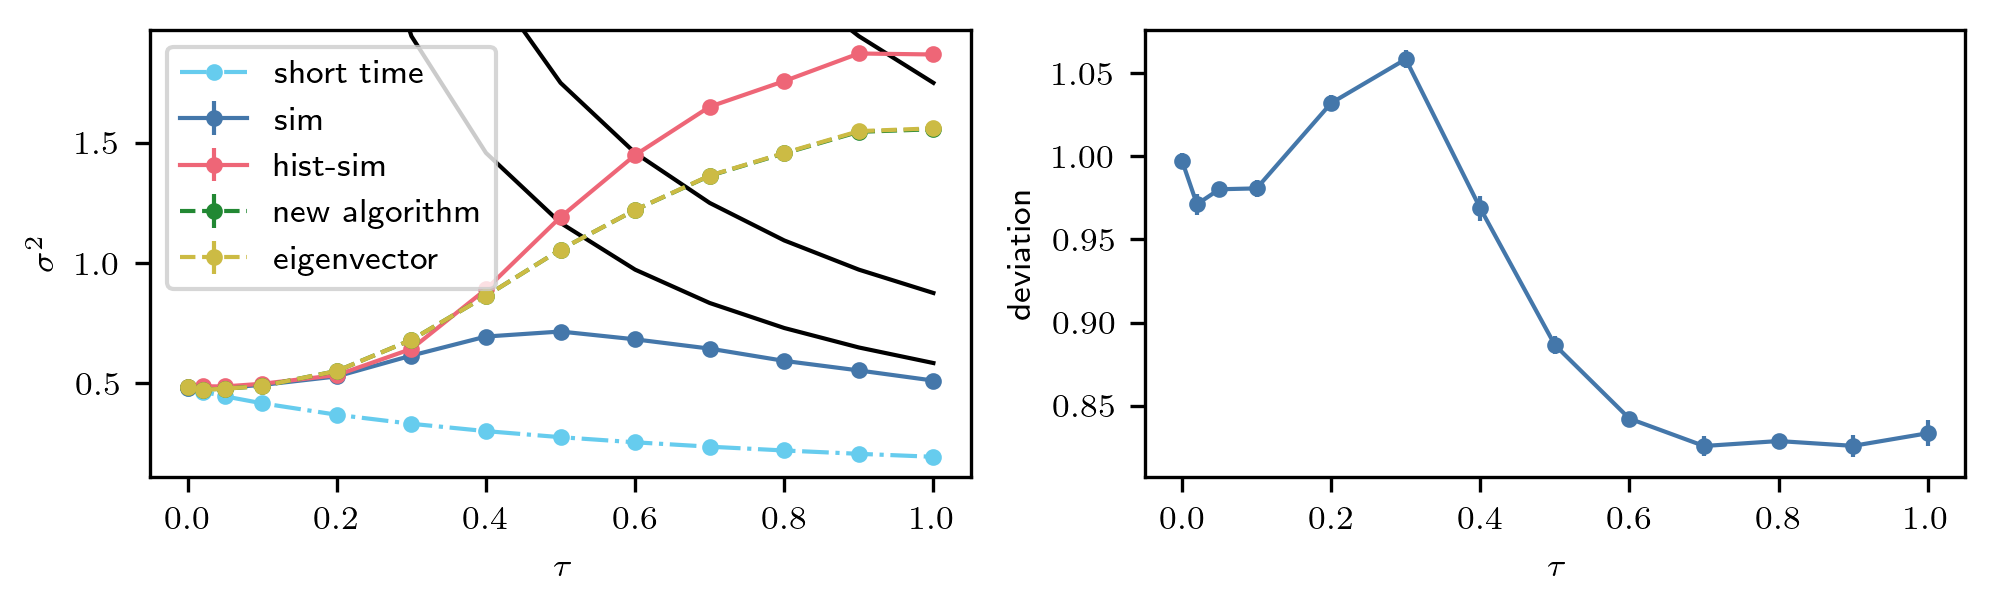

In [7]:
plt.figure(figsize=(two_col,std_height))
ax = plt.subplot(121)
plt.errorbar(ltaus,*sim_vars.T,marker='.', label='sim')
plt.errorbar(ltaus,*sim_hist_vars.T,marker='.', ls= '-', label='hist-sim')
plt.errorbar(ltaus,*num_vars.T,marker='.', ls = '--', label='new algorithm')
plt.errorbar(ltaus,*eig_vars.T,marker='.', ls = '--', label='eigenvector')

plt.plot(ltaus,short_time_approx_var ,marker='.', ls='-.',label='short time')


#plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')
plt.ylim(*plt.ylim())
#auflösungslimit std same as div x0
# plt.plot(ltaus, (2/3)**2*ltaus**(-1), color = 'black')
plt.plot(ltaus[1:], (np.sqrt(7)/2)**2*ltaus[1:]**(-1), color = 'black')
plt.plot(ltaus[1:], 1/2*(np.sqrt(7)/2)**2*ltaus[1:]**(-1), color = 'black')
plt.plot(ltaus[1:], 1/3*(np.sqrt(7)/2)**2*ltaus[1:]**(-1), color = 'black')
# plt.xlim(0,0.2)
# plt.ylim(0.4,0.6)

ax = plt.subplot(122)
plt.errorbar(ltaus, num_vars[:,0]/sim_hist_vars[:,0], 
             yerr = np.sqrt( ( num_vars[:,1]/sim_hist_vars[:,0])**2 + (num_vars[:,0]/sim_hist_vars[:,0]**2*sim_hist_vars[:,1])**2),
                            marker = '.')
plt.xlabel(r'$\tau$')
plt.ylabel(r'deviation')

plt.tight_layout()
# plt.savefig(f'graphics/x4variance_Nx{N_x}_ntau{ntau}.pdf')

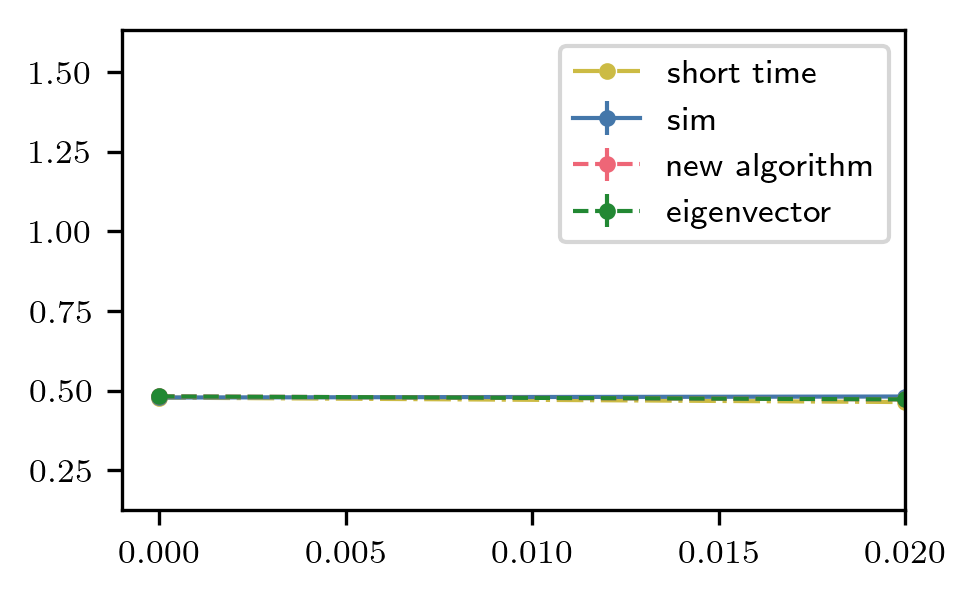

In [8]:
plt.errorbar(ltaus,*sim_vars.T,marker='.', label='sim')
#plt.errorbar(ltaus,*sim_hist_vars.T,marker='.', ls = '-', label='hist-sim')
plt.errorbar(ltaus,*num_vars.T,marker='.', ls = '--', label='new algorithm')
plt.errorbar(ltaus,*eig_vars.T,marker='.', ls = '--', label='eigenvector')

plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')

plt.xlim(-0.001,0.02)
# plt.ylim(0.4,0.6)
plt.legend()



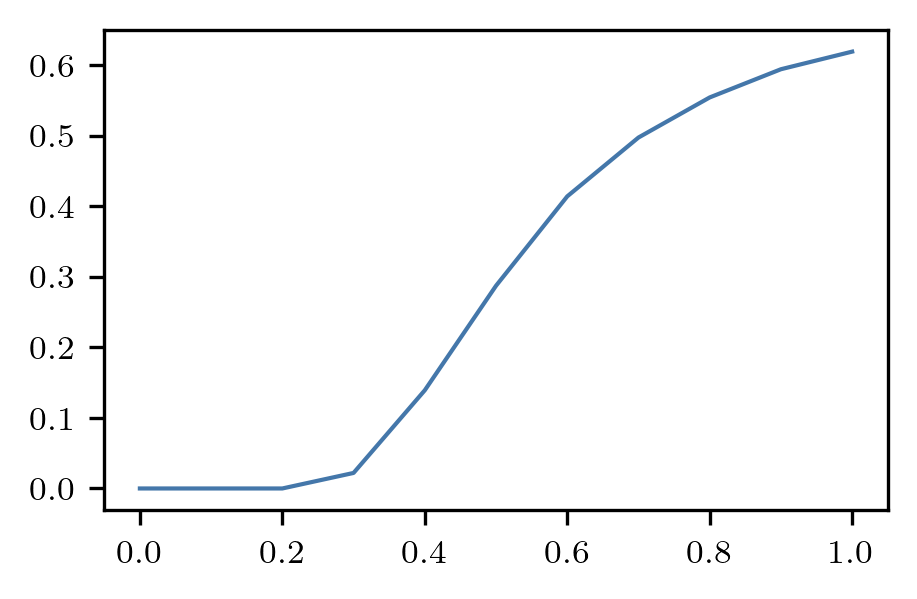

In [9]:
plt.plot(ltaus, escaped_traj)

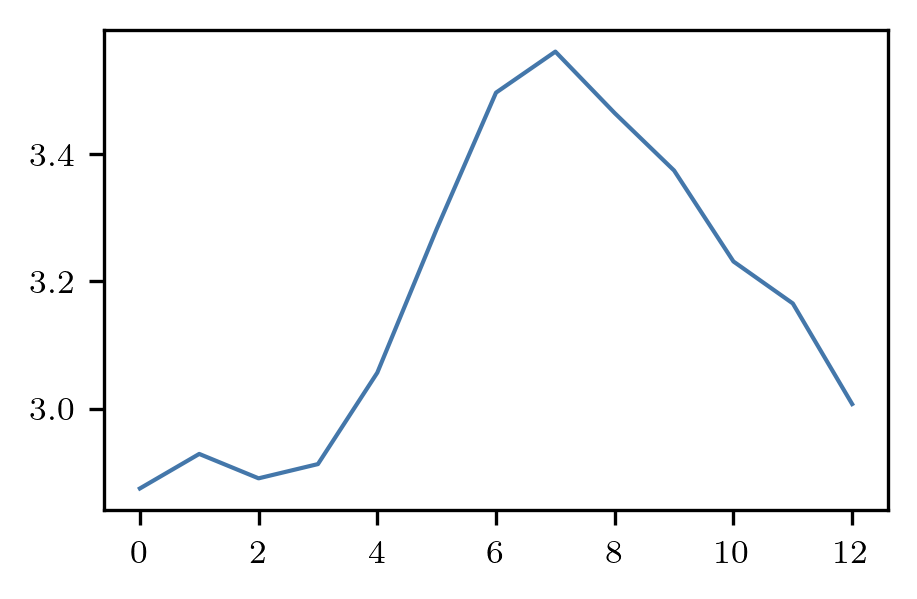

In [10]:
plt.plot(sbs)

# Test short time approx -- approved

In [11]:
# dt = 0.01
# N_loop = 10
# N_p = 2_000
# N_t = 5_000
# N_x = 50

# ltaus = np.concatenate(([0.05], np.arange(0.1,1.1,0.1) ))
# #ltaus = [0.05]
# sim_vars = np.empty((len(ltaus),2))
# sim_hist_vars = np.empty((len(ltaus),2))
# short_time_approx_var = np.empty(len(ltaus))

# for i, tau in enumerate(tqdm(ltaus)):
#     def f_a(x):
#         return -x**3*(1 + 3*tau*x**2)
#     def g_a(x):
#         return (1 + 3*tau*x**2)
    
#     pos = np.empty((N_loop,N_p,N_t))
#     vel = np.empty((N_loop,N_p,N_t))
    
#     pos[:,:,0] = 0
#     vel[:,:,0] = 0
    
#     for j in tqdm(range(1,N_t), leave=False):
#         pos[:,:,j] = pos[:,:,j-1] + vel[:,:,j-1]*dt
#         vel[:,:,j] = f_a(pos[:,:,j]) + g_a(pos[:,:,j])*1/np.sqrt(dt)*np.random.randn(N_loop,N_p)
    
#     pos_filter = pos.copy()
#     if tau > 0:
#         pos_filter[pos_filter**2 > 7/4/tau] = np.nan
#     sim_var = np.nanvar(pos_filter, axis = 1)
    
#     sb = 3*np.sqrt(np.max(sim_var))
#     dx = 2*sb/(N_x-1)
#     x_s = np.arange(-sb,sb+1e-6,dx)
#     bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
    
    
#     sim_hists = np.swapaxes(np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1,2)
#     sim_hist_var =  np.apply_along_axis(get_var_hist,-1, sim_hists, x_s=x_s)
    
#     short_time_p = get_p_x4_short_time(x_s, tau)
#     short_time_approx_var[i] = get_var_hist(short_time_p,x_s)

#     mean_sim_vars = np.mean(sim_var[:,-500:], axis = 1)
#     sim_vars[i] = (np.mean(mean_sim_vars), np.std(mean_sim_vars)/np.sqrt(N_loop))

#     mean_sim_hist_var = np.mean(sim_hist_var[:,-500:], axis = 1)
#     sim_hist_vars[i] = (np.mean(mean_sim_hist_var), np.std(mean_sim_hist_var)/np.sqrt(N_loop))

In [12]:
# plt.plot(sim_var[0])
# plt.plot(sim_hist_var[0])
# plt.hlines(short_time_approx_var[-1], *plt.xlim())
# plt.xlim(0,100)

In [13]:
# plt.plot(ltaus, short_time_approx_var, label = 'short time')
# plt.plot(ltaus, sim_hist_vars[:,0], label = 'sim hists')
# plt.plot(ltaus, sim_vars[:,0], label = 'sim')
# plt.legend()